In [1]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
hs_2017 = pd.read_csv("hs_2017.csv")

# creating categorical variable from existing column - https://stackoverflow.com/a/49269107
# ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] < 1080,'sat_high_level'] = 0
# ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >= 1080,'sat_high_level'] = 1

# subsetting to remove rows where no average SAT score was reported
# ml_hs_2017 = ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >0]

In [2]:
# zero_counts = []
#for column in ml_hs_2017:
#    zero_counts.append({'Column': column, 'count': np.sum((ml_hs_2017[column]==0)), 'Percentage': np.sum((ml_hs_2017[column]==0)/len(ml_hs_2017))})

In [3]:
# zero_counts = pd.DataFrame(zero_counts)
# to_drop = zero_counts.loc[zero_counts['Percentage'] >= .999]
# hs_2017 = ml_hs_2017.drop(to_drop['Column'], axis=1)
# hs_2017.info()

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='sat_high_level',data=hs_2017, palette='hls')
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
Y_sat_high=hs_2017['sat_high_level'].values
Y = Y_sat_high
del hs_2017['sat_high_level']
X_highSchools=hs_2017# remove .values if necessary

In [6]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [7]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)


In [8]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=4 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:    8.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [9]:
#Diplay the top model parameters

regGridSearch.best_estimator_

LogisticRegression(C=0.001, class_weight='none', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [10]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)


The average accuracy for all cv folds is: 			 0.86706
The average precision for all cv folds is: 			 0.81852
The average recall for all cv folds is: 			 0.83786
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.882353,0.928571,0.764706
1,0.905882,0.937500,0.833333
2,0.847059,0.790698,0.894737
3,0.800000,0.722222,0.787879
4,0.811765,0.687500,0.785714
5,0.811765,0.735294,0.781250
6,0.917647,0.825000,1.000000
7,0.929412,0.909091,0.909091
8,0.858824,0.866667,0.764706
9,0.905882,0.782609,0.857143


In [11]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)


             precision    recall  f1-score   support

        0.0       0.88      0.86      0.87       262
        1.0       0.78      0.81      0.79       159

avg / total       0.84      0.84      0.84       421

[[226  36]
 [ 31 128]]
0.8408551068883611


In [12]:
# Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analasys 
X_highSchools_Scl = scaler.transform(X_highSchools)

In [13]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    3.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [14]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)


The average accuracy for all cv folds is: 			 0.84588
The average precision for all cv folds is: 			 0.79879
The average recall for all cv folds is: 			 0.80629
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.870588,0.925926,0.735294
1,0.905882,0.937500,0.833333
2,0.776471,0.731707,0.789474
3,0.752941,0.650000,0.787879
4,0.788235,0.647059,0.785714
5,0.823529,0.774194,0.750000
6,0.917647,0.882353,0.909091
7,0.917647,0.882353,0.909091
8,0.800000,0.774194,0.705882
9,0.905882,0.782609,0.857143


In [16]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools_Scl, Y, 10)

             precision    recall  f1-score   support

        0.0       0.88      0.87      0.88       262
        1.0       0.79      0.80      0.80       159

avg / total       0.85      0.85      0.85       421

[[229  33]
 [ 32 127]]
0.8456057007125891


In [17]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_highSchools, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
   estimator=LogisticRegression(C=1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 176


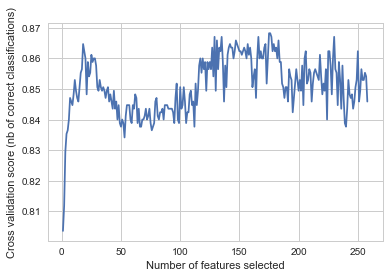

In [18]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [19]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_highSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top50features = rfe_ft_imp_df.head(50)

top50features

,feature_names,weights
174,GraduationRate_5yr_Female,0.868235
175,ACTCompositeScore_UNCMin_AIG,0.868235
128,EOCSubjects_CACR_Black,0.867059
165,GraduationRate_5yr_Black,0.867059
229,SBE District_Sandhills,0.867059
176,EOCEnglish2_CACR_TwoorMoreRaces,0.867059
134,ACTScience_ACTBenchmark_TwoorMoreRaces,0.867059
146,ACTCompositeScore_UNCMin_Hispanic,0.865882
130,lea_avg_daily_attend_pct,0.865882
182,Developing_TCHR_Standard 5_Pct,0.865882


In [20]:
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Columns: 258 entries, Unnamed: 0 to EOCBiology_CACR_Black
dtypes: float64(238), int64(20)
memory usage: 848.7 KB


In [21]:
X_highSchools=pd.DataFrame(X_highSchools)

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#Use recursive feature elimination to get the best features for our model
#(We already did this earlier, but I am including it again below in comment for a complete example!)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
X_BestFeatures = rfecv.fit_transform(X_highSchools, Y)

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_BestFeatures, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [23]:
EvaluateClassifierEstimator(grid.best_estimator_, X_BestFeatures, Y, cv)

The average accuracy for all cv folds is: 			 0.88941
The average precision for all cv folds is: 			 0.86902
The average recall for all cv folds is: 			 0.83705
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.894118,0.903226,0.823529
1,0.894118,0.909091,0.833333
2,0.858824,0.825000,0.868421
3,0.823529,0.781250,0.757576
4,0.882353,0.821429,0.821429
5,0.882353,0.923077,0.750000
6,0.905882,0.903226,0.848485
7,0.941176,0.911765,0.939394
8,0.870588,0.848485,0.823529
9,0.941176,0.863636,0.904762


In [24]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_BestFeatures, Y, 10)

             precision    recall  f1-score   support

        0.0       0.88      0.90      0.89       262
        1.0       0.83      0.80      0.81       159

avg / total       0.86      0.86      0.86       421

[[236  26]
 [ 32 127]]
0.8622327790973872


In [25]:
X_highSchools=pd.DataFrame(X_highSchools) # casting as dataframe for column interpretation

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = X_highSchools.columns.values[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

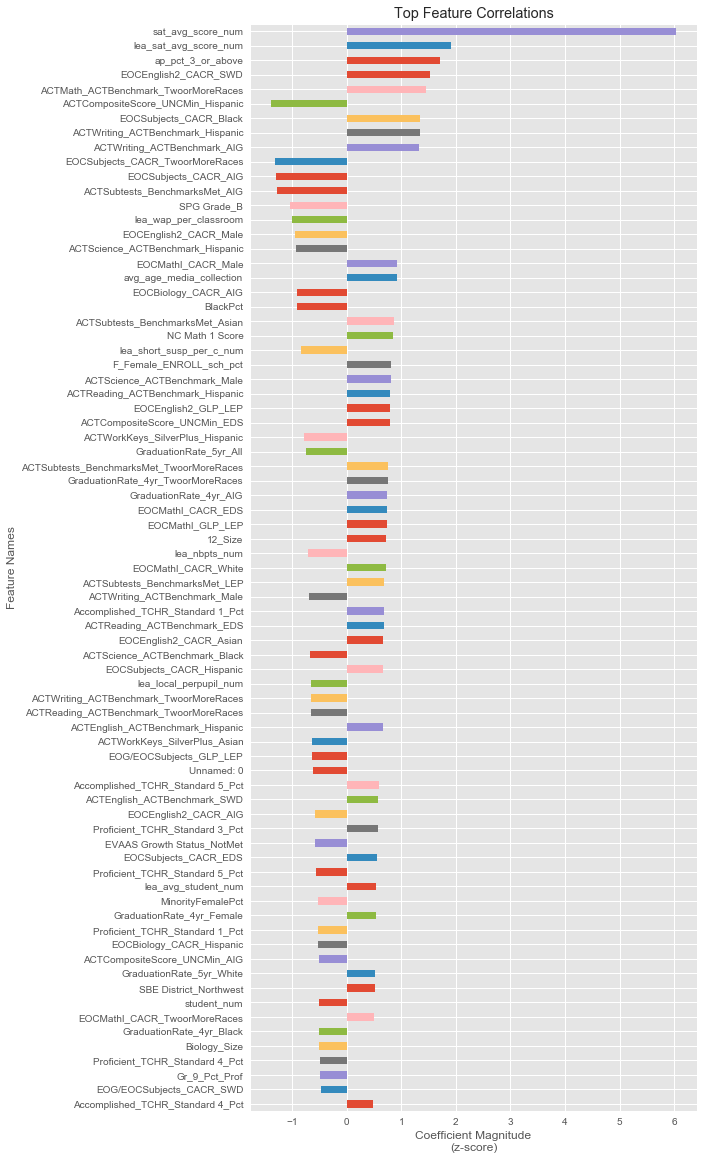

In [26]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt

%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75) # obtains the 75 most highly-weighted attributes
wt_plt_df = pd.DataFrame(wt_plt_df)
wt_plt_df.sort_values(by='absolute_weights', inplace=True, ascending=True) # reverses the sorting

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='barh', figsize=(8,20))

ax.set_title("Top Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

plt.show()

## Support Vector Machines (SVM)

Support Vector Machines analyze data for logical breaks and are useful for predicting classification of a record.  

In [27]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

X_highSchools=hs_2017.values # re-instantiating X to get values f

for train_indices, test_indices in cv.split(X_highSchools,Y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X_highSchools[train_indices]
    y_train = Y[train_indices]
    
    X_test = X_highSchools[test_indices]
    y_test = Y[test_indices]
    
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [28]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# train the SVM model
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set preditions

#Get the model accuracy and the confusion matrix
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('The accuracy of the SVM is:', acc )
print(conf)

The accuracy of the SVM is: 0.8941176470588236
[[58  6]
 [ 3 18]]


The resulting SVM model shows an accuracy rate of 89% which is slightly better than the logistic regression performed previously.  The confusion rate shows us the actual vs. predicted values.

| n = 88 | Predicted: 0 | Predicted: 1 |
| ------ | ------------ | ------------ |
| Actual: 0 | 58 | 6 |
| Actual: 1 | 3 | 18 |

The confusion matrix shows us the number of true positives, or the correct prediction of high SAT scores as 18.  The number of false positives, or incorrectly predicted high SAT scores as 3.  This are also referred to as type I errors.  The true negatives, or correct predicted of schools without high SAT scores is 58.  While the false negatives, or incorrectly classified schools that don't have high SAT come in at 6.  False negatives are also known as type II errors.  This results in the SVM being a pretty good predictor of both schools with high SAT scores and without high SAT scores.

In [29]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(208, 258)
(208,)
[104 104]


In [30]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# make a dataframe of the training data
df_tested_on = hs_2017.loc[train_indices] # saved from above, the indices chosen for training
# get the support vectors from the trained model
df_support = df_tested_on.loc[svm_clf.support_,:]

df_support['sat_high_level'] = Y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
hs_2017['sat_high_level'] = Y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 4 to 334
Columns: 259 entries, Unnamed: 0 to sat_high_level
dtypes: float64(259)
memory usage: 422.5 KB


d:\programfiles\python36\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


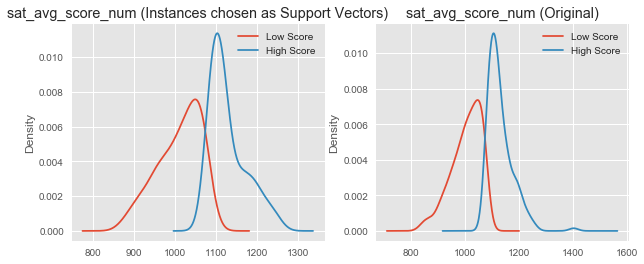

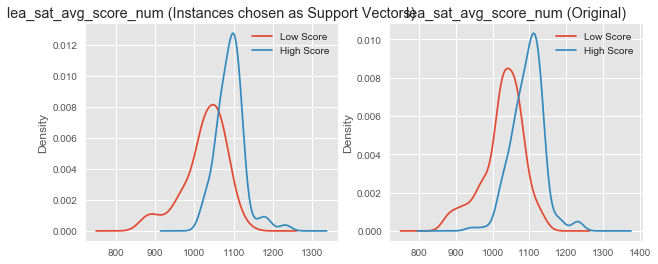

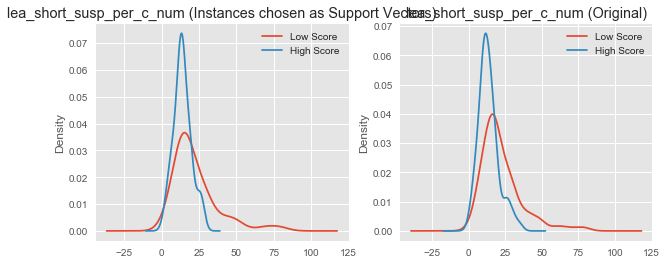

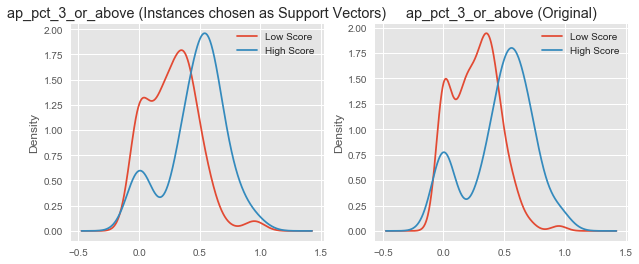

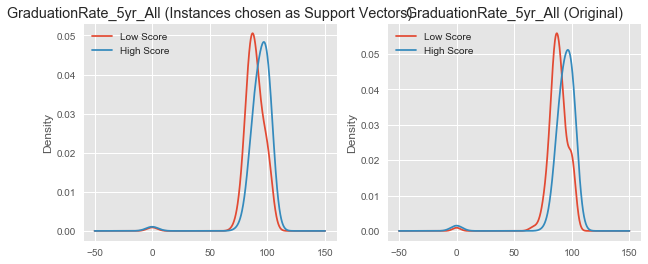

In [31]:
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['sat_high_level'])
df_grouped = hs_2017.groupby(['sat_high_level'])

# plot KDE of Different variables
vars_to_plot = ['sat_avg_score_num','lea_sat_avg_score_num','lea_short_susp_per_c_num', 'ap_pct_3_or_above', 'GraduationRate_5yr_All']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Low Score','High Score'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Low Score','High Score'])
    plt.title(v+' (Original)')

The graphs show the kernel density estimate of the original data, which appears on the right, versus the support vectors which appear on the left.

The SAT and LEA SAT scores are continuous variables and reflect an expected split between lower and higher SAT scores. since the dividing line for the binary is based off the continuous score.  The graduation rate for 5 year cohorts and the number of kids in ap classes are both measured in percent and thus, the density scores fall between 0.0 and 1.0.  Finally the number of short duration school suspensions in a given LEA is continuous data that has been normalized per 100 students.  

We can see different trends in each of the variables.  Graduation rate seems to contain slightly higher densities toward 100 percent than the original data.  The percent of ap students shows a small bump around 0 that could indicate missing values affecting the model or a lack of AP programs but the distribution between original and SVM appears similar although with less noticable troughs and peaks.  